In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import nltk
import re
import warnings
warnings.filterwarnings('ignore')

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\avinash\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\avinash\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\avinash\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [8]:
print("Loading the dataset...")
df = pd.read_csv('Amazon product Reviews.csv')

print("Dataset Shape:", df.shape)
print("\nDataset Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())

Loading the dataset...
Dataset Shape: (568454, 10)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB
None

Missing Values:
Id                         0
ProductId                  0
UserId                     0
ProfileName               2

In [9]:
df['sentiment'] = df['Score'].apply(lambda x: 'positive' if x > 3 else ('negative' if x < 3 else 'neutral'))

df['helpfulness_ratio'] = df.apply(
    lambda x: x['HelpfulnessNumerator'] / x['HelpfulnessDenominator'] 
    if x['HelpfulnessDenominator'] != 0 else 0, 
    axis=1)


Sentiment Distribution:
sentiment
positive    443777
negative     82037
neutral      42640
Name: count, dtype: int64


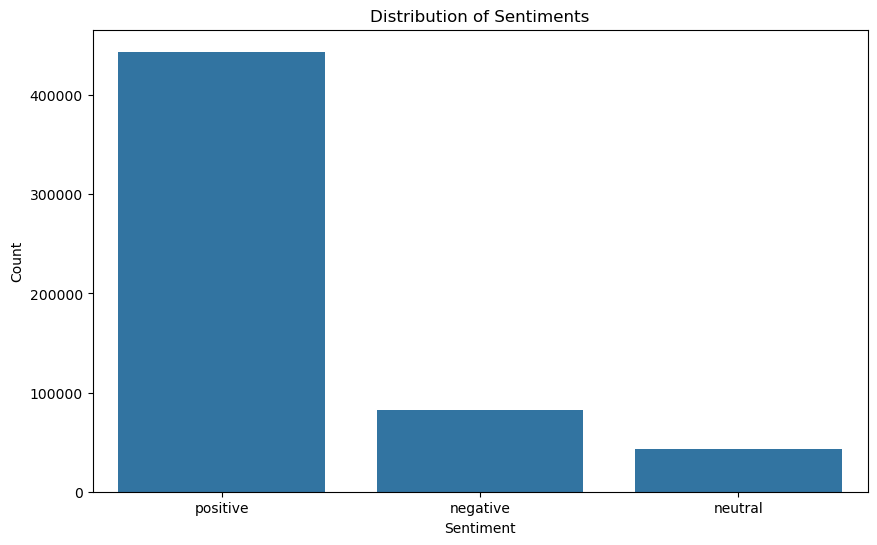

In [10]:
print("\nSentiment Distribution:")
print(df['sentiment'].value_counts())

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='sentiment')
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [11]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = ' '.join(text.split())
    return text
df['full_review'] = df['Summary'] + ' ' + df['Text']
df['cleaned_review'] = df['full_review'].apply(clean_text)

In [12]:
print("\nExtracting features...")
tfidf = TfidfVectorizer(max_features=5000, stop_words='english',ngram_range=(1, 2))
X = tfidf.fit_transform(df['cleaned_review'])
y = df['sentiment']


Extracting features...


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("\nTraining model...")
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


Training model...



Model Accuracy: 0.8825236826133995

Classification Report:
              precision    recall  f1-score   support

    negative       0.76      0.73      0.75     16181
     neutral       0.55      0.24      0.33      8485
    positive       0.91      0.97      0.94     89025

    accuracy                           0.88    113691
   macro avg       0.74      0.65      0.67    113691
weighted avg       0.87      0.88      0.87    113691



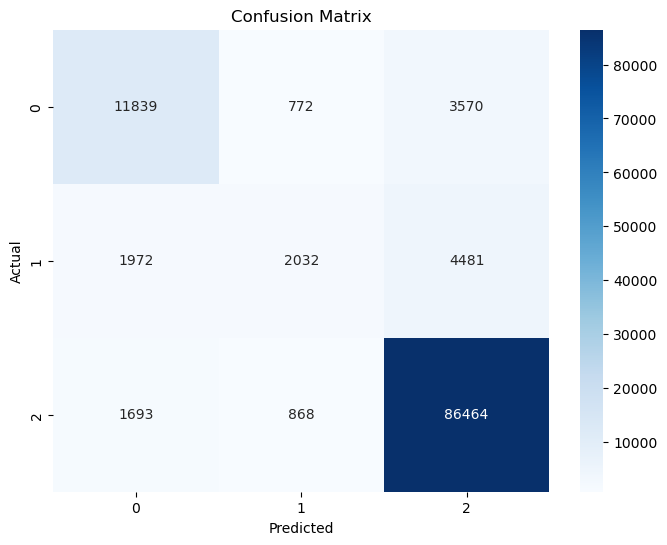

In [14]:
accuracy = accuracy_score(y_test, y_pred)
print("\nModel Accuracy:", accuracy)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

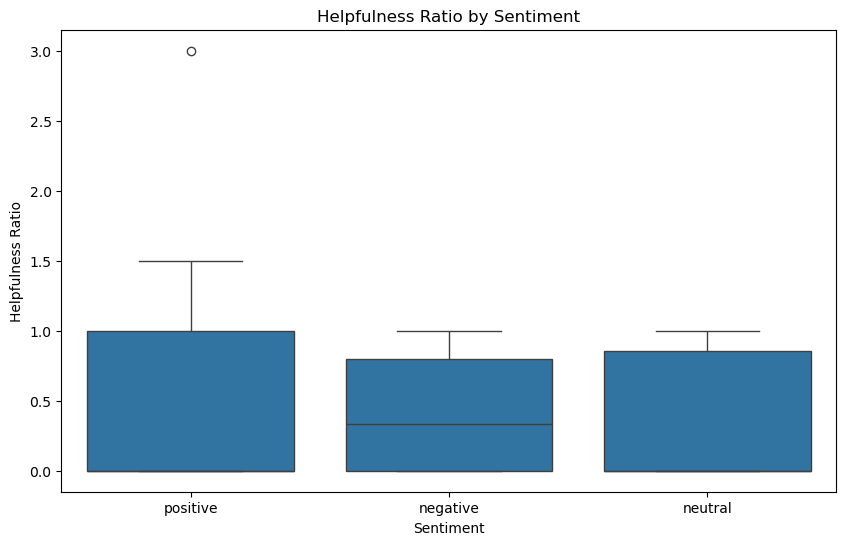

<Figure size 1200x600 with 0 Axes>

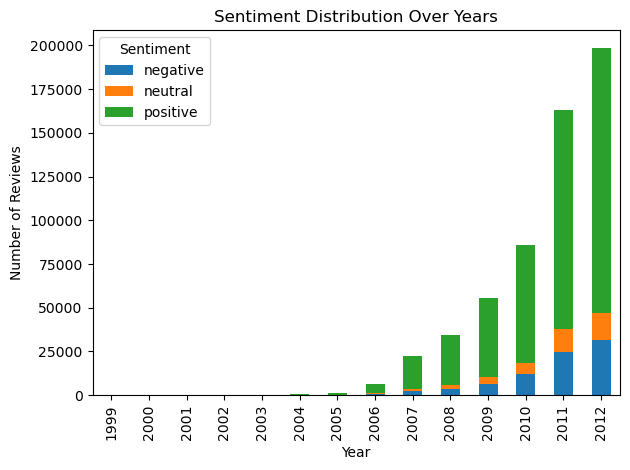

In [15]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='sentiment', y='helpfulness_ratio', data=df)
plt.title('Helpfulness Ratio by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Helpfulness Ratio')
plt.show()

df['TimeStamp'] = pd.to_datetime(df['Time'], unit='s')
df['Year'] = df['TimeStamp'].dt.year

plt.figure(figsize=(12, 6))
yearly_sentiment = df.groupby(['Year', 'sentiment']).size().unstack()
yearly_sentiment.plot(kind='bar', stacked=True)
plt.title('Sentiment Distribution Over Years')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

In [16]:
user_stats = df.groupby('UserId').agg({'Id': 'count','Score': 'mean','helpfulness_ratio': 'mean'}).rename(columns={'Id': 'review_count'})
print("\nUser Statistics:")
print("\nReviews per user:")
print(user_stats['review_count'].describe())
print("\nAverage score per user:")
print(user_stats['Score'].describe())


User Statistics:

Reviews per user:
count    256059.000000
mean          2.220012
std           4.443361
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         448.000000
Name: review_count, dtype: float64

Average score per user:
count    256059.000000
mean          4.168984
std           1.313261
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: Score, dtype: float64


In [17]:
from collections import Counter
import itertools
def get_top_words(text_series, n=20):
    words = ' '.join(text_series).split()
    return pd.DataFrame(Counter(words).most_common(n), columns=['Word', 'Count'])
for sentiment in df['sentiment'].unique():
    print(f"\nTop 20 words in {sentiment} reviews:")
    top_words = get_top_words(df[df['sentiment'] == sentiment]['cleaned_review'])
    print(top_words)


Top 20 words in positive reviews:
    Word    Count
0    the  1398057
1      i  1116814
2    and  1032157
3      a   974015
4     to   775220
5     it   702260
6     of   605781
7     is   582557
8   this   520429
9    for   462894
10    in   423922
11    my   390147
12  that   312999
13  with   281003
14   but   271587
15  have   270841
16   you   265639
17   are   258833
18   not   221785
19  they   216978

Top 20 words in negative reviews:
    Word   Count
0    the  331942
1      i  260363
2    and  184887
3      a  170468
4     to  164854
5     it  151298
6     of  137263
7   this  117502
8     is  103528
9    not   91716
10    in   86134
11   for   78026
12   was   77733
13  that   76164
14   but   67554
15    my   64581
16  have   50856
17  with   50484
18  they   48224
19  like   47152

Top 20 words in neutral reviews:
    Word   Count
0    the  190943
1      i  138353
2      a  114039
3    and   95974
4     to   92919
5     it   88819
6     of   78153
7     is   64986
8   this

In [18]:
results = {'accuracy': accuracy,'classification_report': classification_report(y_test, y_pred),'confusion_matrix': cm,'model': model,'vectorizer': tfidf}
print("\nAnalysis Summary:")
print(f"Total reviews analyzed: {len(df)}")
print(f"Model accuracy: {accuracy:.4f}")
print("\nSentiment distribution:")
print(df['sentiment'].value_counts(normalize=True).apply(lambda x: f"{x:.2%}"))


Analysis Summary:
Total reviews analyzed: 568454
Model accuracy: 0.8825

Sentiment distribution:
sentiment
positive    78.07%
negative    14.43%
neutral      7.50%
Name: proportion, dtype: object
